# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from operator import itemgetter
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

%matplotlib inline

<font color=teal>functions<font>

In [101]:
def decompose_plot(df: pd.DataFrame):
    # Make a variable called decomposition, and assign it y passed to seasonal_decompose()
    decomposition = seasonal_decompose(df, model='multiplicative')

    # Make three variables for trend, seasonal and residual components respectively.
    # Assign them the relevant features of decomposition
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the original data, the trend, the seasonality, and the residuals
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 15))

    ax[0, 0].plot(decomposition.observed, label='observed')
    ax[0, 0].legend()
    ax[0, 0].set_title("Observed Values")

    ax[0, 1].plot(trend, label='Trend')
    ax[0, 1].legend()
    ax[0, 1].set_title("Mean Trend line is upward")

    ax[1, 0].plot(seasonal, label='Seasonal')
    ax[1, 0].legend()
    ax[1, 0].set_title("Seasonal fluctuation - There is a dip at the end of each year, starting in October")

    ax[1, 1].plot(residual, label='Residuals')
    ax[1, 1].legend()
    ax[1, 1].set_title("Random Variations")

    plt.show()

In [102]:
def plot_time_series(data, title):
    plt.figure(figsize=(30, 10))
    plt.plot(data)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show ticks for each month
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Show ticks for each month
    plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels, align to the right, and adjust fontsize

    plt.xlabel('Months')
    plt.ylabel("Sales")
    plt.title(title)
    plt.show()

In [103]:
def get_time_series_data(file):

    cigData = pd.read_csv(file, index_col=0).dropna()
    cigData.rename(columns={'Time': 'Month'}, inplace=True)

    cigData.Month = pd.to_datetime(cigData.Month, format='%Y-%m')
    cigData.rename(columns={'#CigSales': 'cig_sales'}, inplace=True)

    cigData.cig_sales = cigData.cig_sales.astype('int64')

    cigData.set_index('Month', inplace=True)
    cigData.cig_sales = np.log(cigData.cig_sales)
    return cigData

In [104]:
def train_test_split(cigData):

    # Make train and test variables, with 'train, test'
    split = int(len(cigData) * 0.8)
    df_train, df_test = cigData[0:split], cigData[split:len(cigData)]
    return df_train, df_test

In [105]:

def test_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    data.dropna(inplace=True)
    split = int(len(data) * 0.8)
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past = [x for x in train.cig_sales]
    # make predictions
    predictions = list()
    for i in range(len(test)):
        test_model_fit = run_arima(data=past, order=arima_order)
        predict = test_model_fit.forecast()[0]
        predictions.append(predict)
        past.append(test.iloc[i].cig_sales)
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error, test


# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_arima(data, p_values, q_values):
    test_results = []
    best=None
    for p_val in p_values:
        for q_val in q_values:
            order = (p_val, 1, q_val)
            loss, _ = test_model(data=data, arima_order=order)
            record = dict(order=order, loss=loss)
            if best is None or loss < best['loss']:
                best = record
            test_results.append( record )

    return sorted(test_results, key=itemgetter('loss')), best

def run_arima(data, order):
    model = ARIMA(data, order=order)
    model_fit_ = model.fit()
    return model_fit_


### 1b. Load the data
Call the variable `cigData`.

In [106]:
cigData = get_time_series_data('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand.

Check out the columns feature of the data. How many columns are there?

In [107]:
cigData.shape[1]


1

Let's check out the data types of our columns.

In [108]:
cigData.dtypes

cig_sales    float64
dtype: object

Check whether there are any null values.

In [109]:
cigData.isna().sum().sum()

0

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

<font color=teal>Already done during load</font>

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

<font color=teal>Already done during load</font>

Call a head() to check this has worked.

In [110]:
cigData.head()

,cig_sales
Month,
1949-01-01,13.815623
1949-02-01,13.815629
1949-03-01,13.815643
1949-04-01,13.815640
1949-05-01,13.815632


### 2c. Type conversions

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

Perfect!

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column.

<font color=teal>Save a train test copy of the original data</font>

Check the type of our new variable.

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [111]:
cigData.describe()

,cig_sales
count,144.000000
mean,13.815791
std,0.000120
min,13.815615
25%,13.815691
50%,13.815776
75%,13.815871
max,13.816132


Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

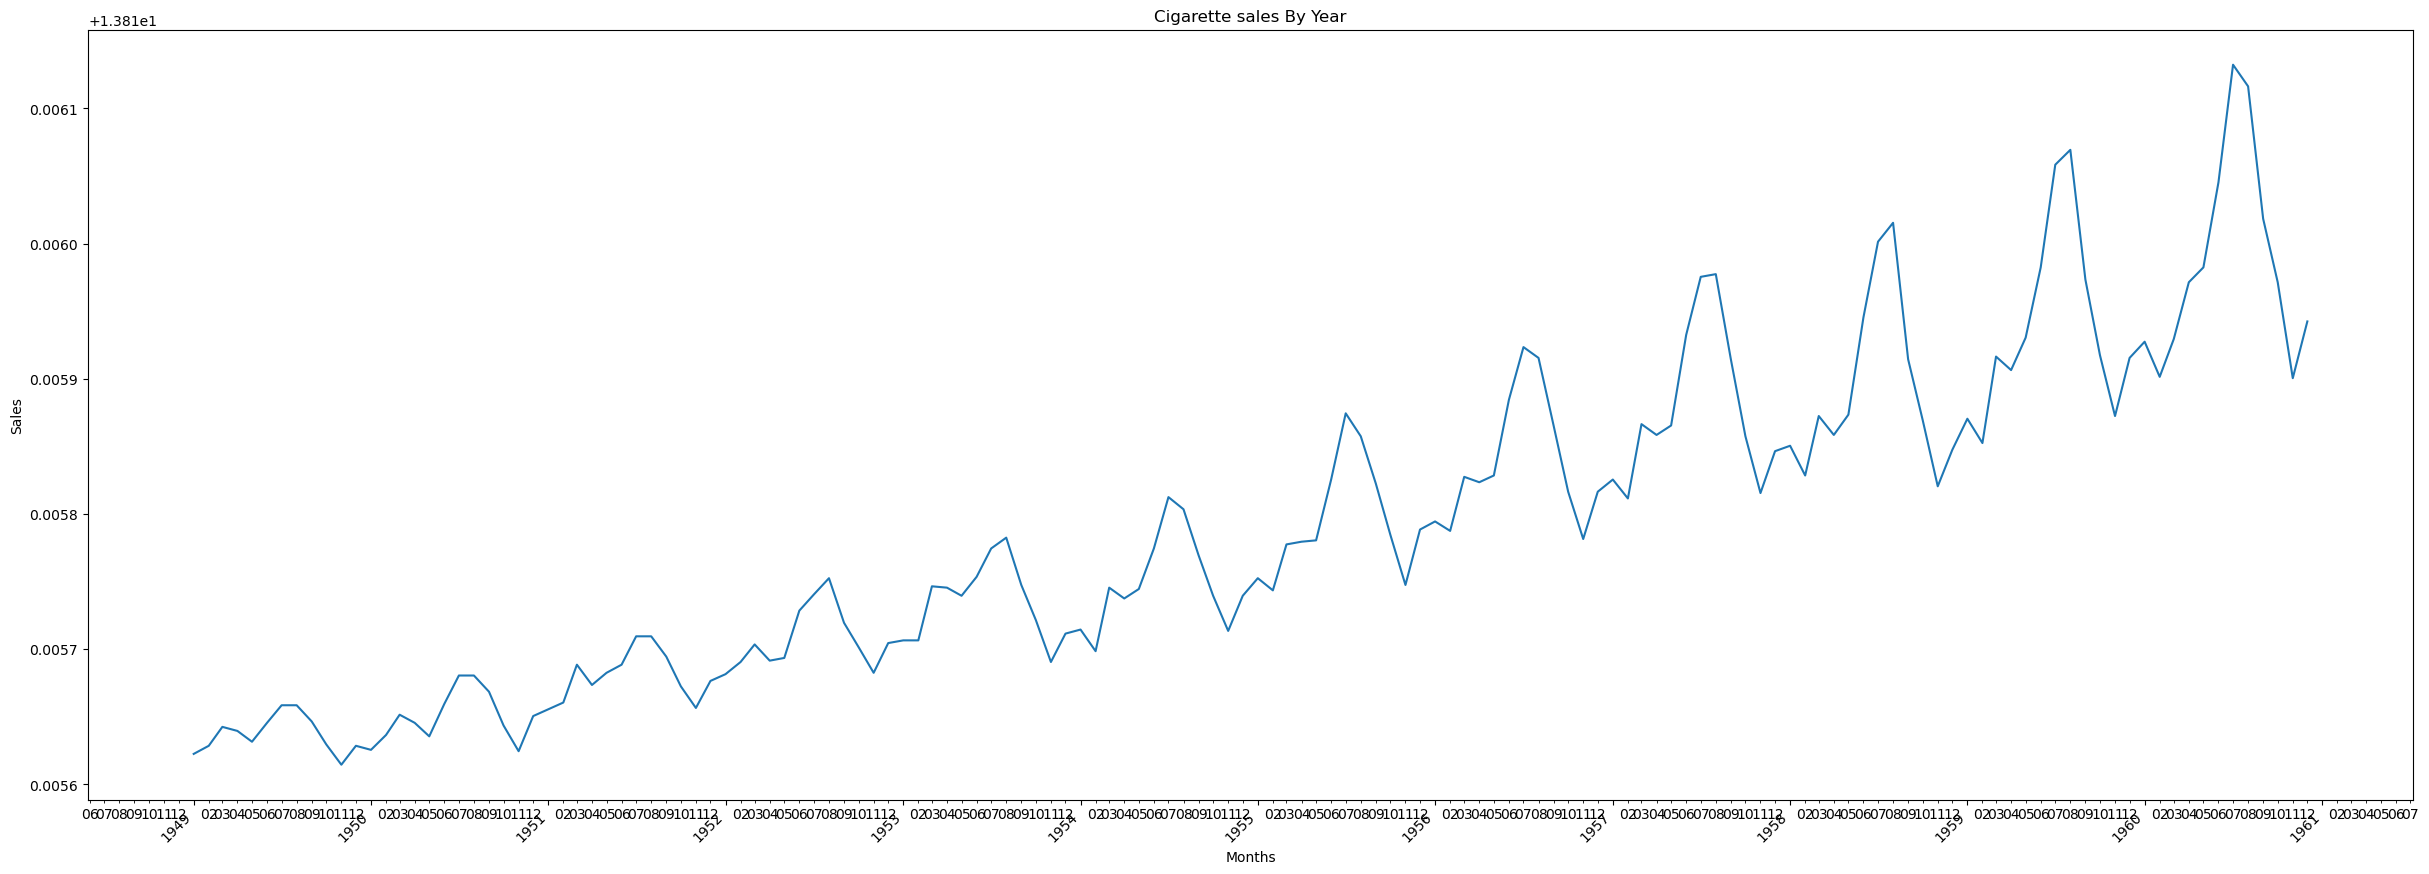

In [112]:
plot_time_series(cigData, "Cigarette sales By Year")

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

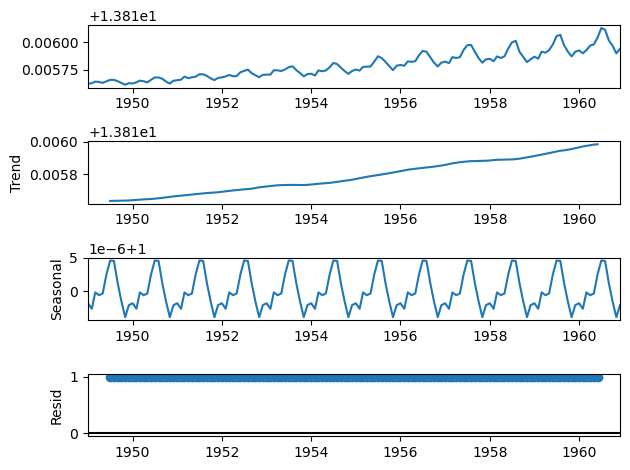

In [113]:
result = seasonal_decompose(cigData, model='multiplicative')
result.plot()
pyplot.show()

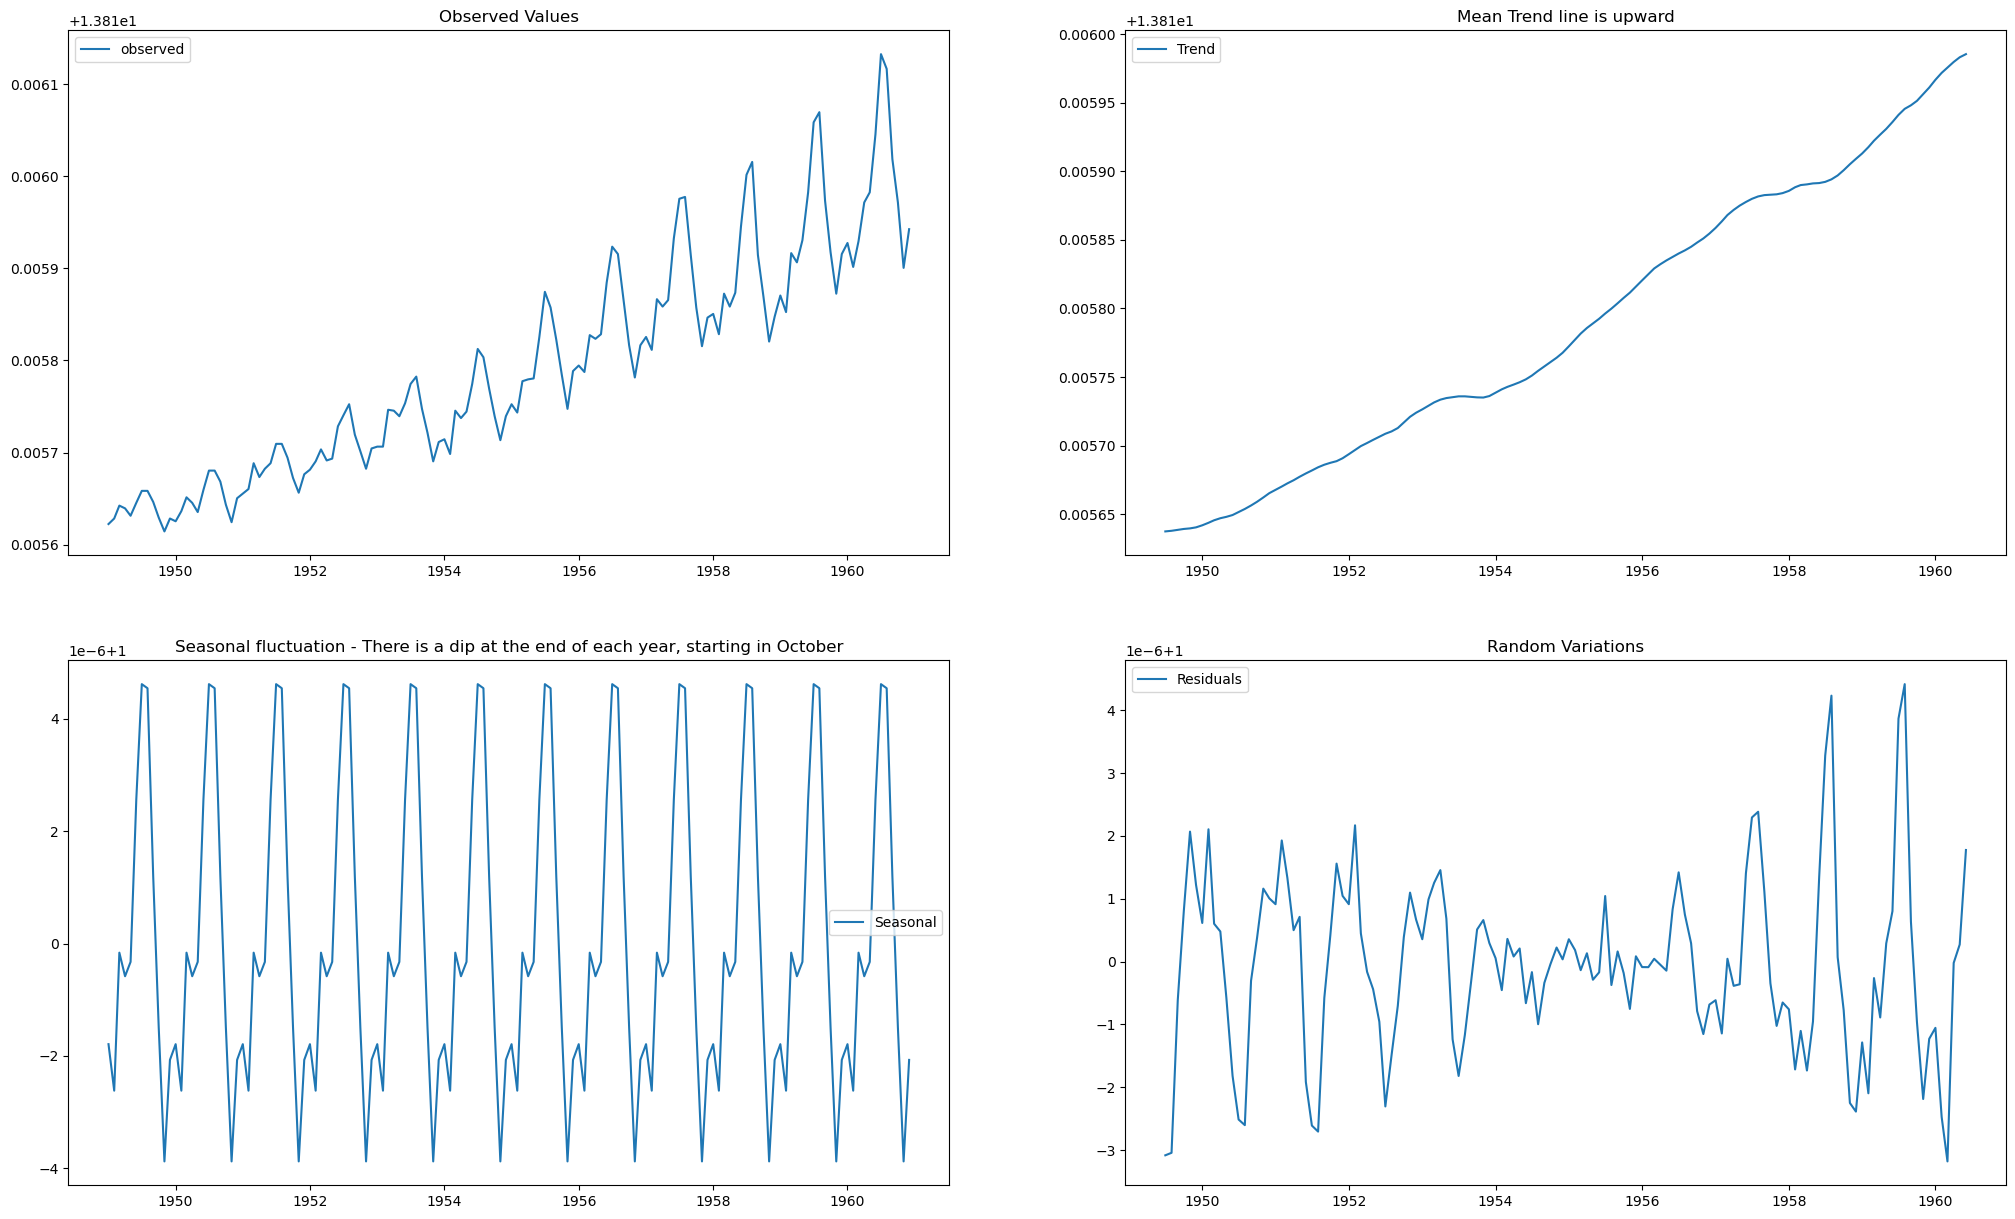

In [114]:
decompose_plot(cigData)

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

<font color=teal>kpps</font>

In [115]:
_, p_value, _, criticals = kpss(cigData)

print("p_value   :", p_value)
print("criticals :", criticals)

p_value   : 0.01
criticals : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


<font color=teal>adfuller</font>

In [116]:
adf_test = adfuller(cigData)
print(f"p-value is {adf_test[1]}")

p-value is 0.9918716322543342


Since our KPSS p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data.

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like.

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now.

<font color=teal>already took the log()</font>

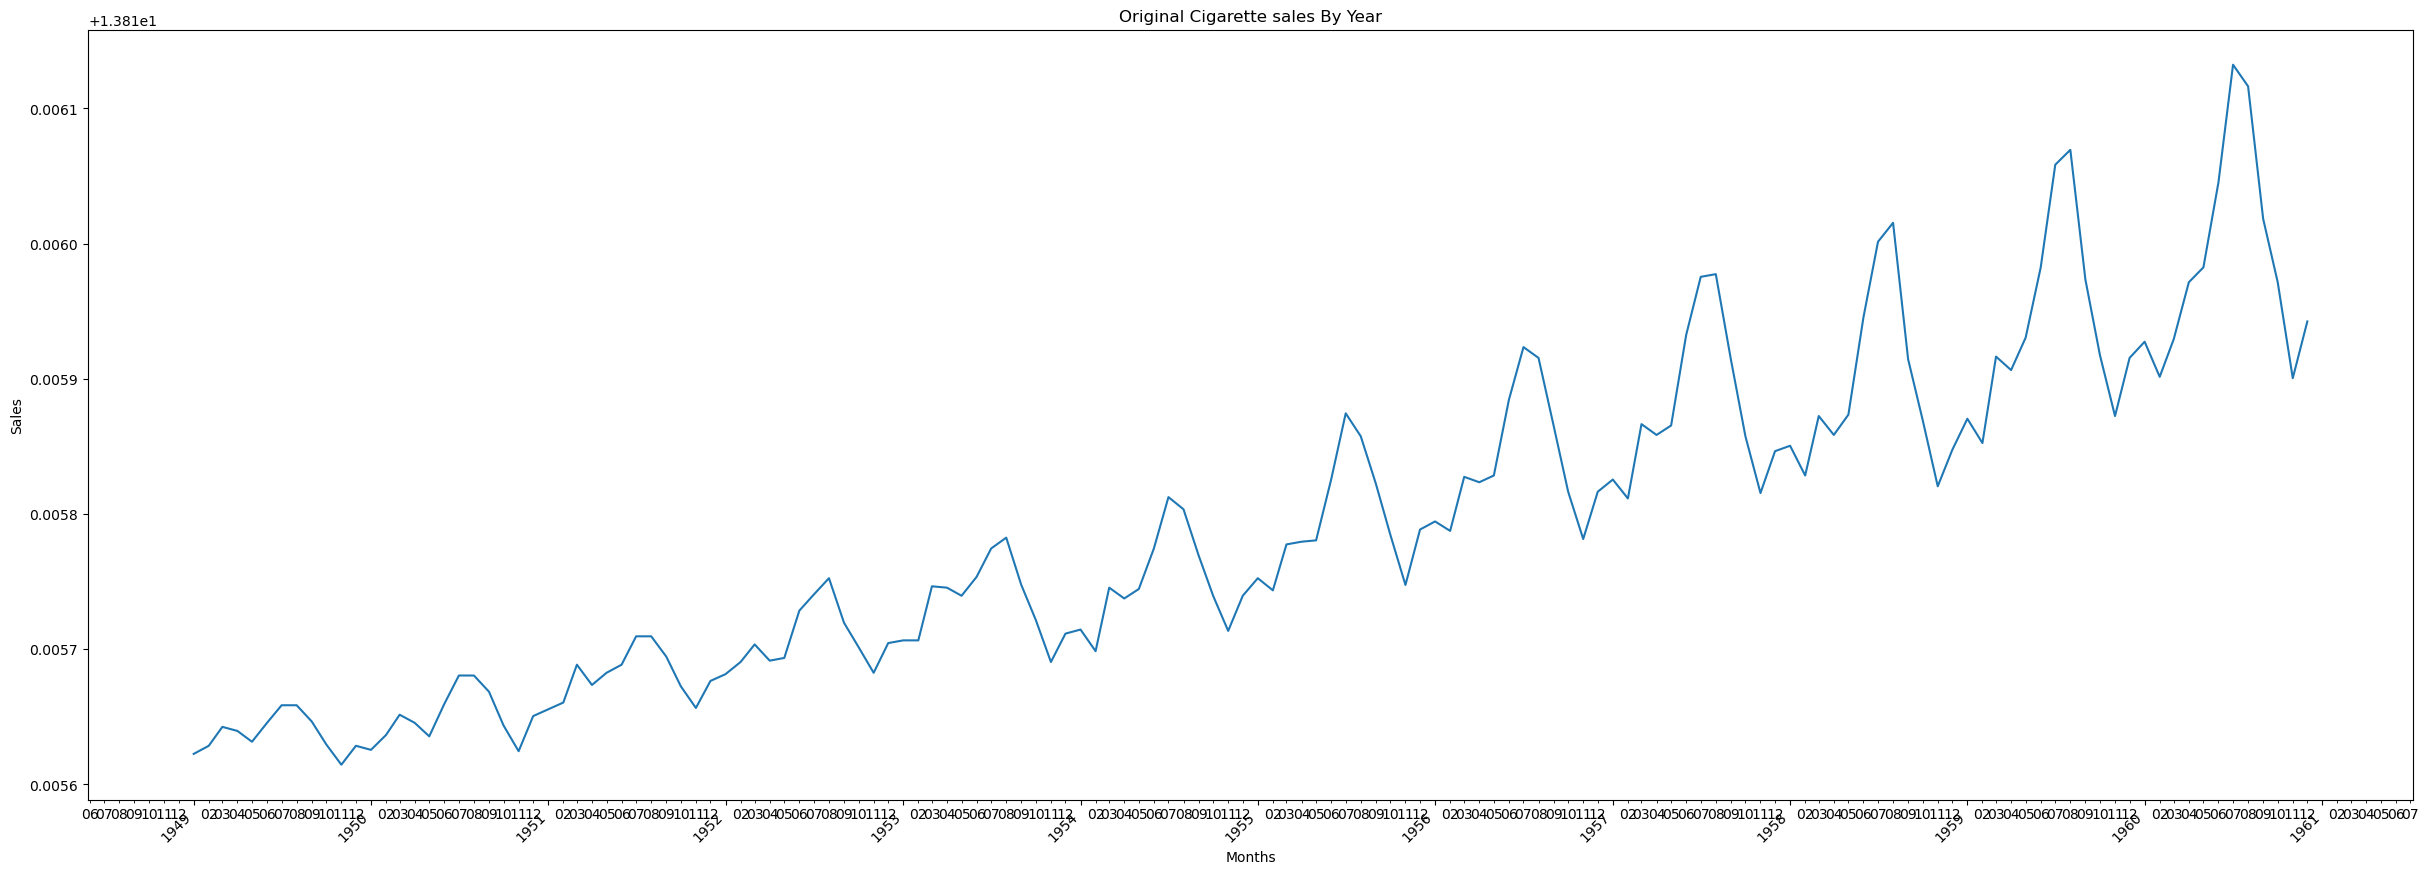

In [117]:

plot_time_series(cigData, "Original Cigarette sales By Year")


When you plot this, you can see how the variance in our data now remains contant over time.

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

<font color=teal>differenced</font>

In [118]:
diff_df = cigData.diff().dropna()
diff_df.head()

,cig_sales
Month,
1949-02-01,0.000006
1949-03-01,0.000014
1949-04-01,-0.000003
1949-05-01,-0.000008
1949-06-01,0.000014


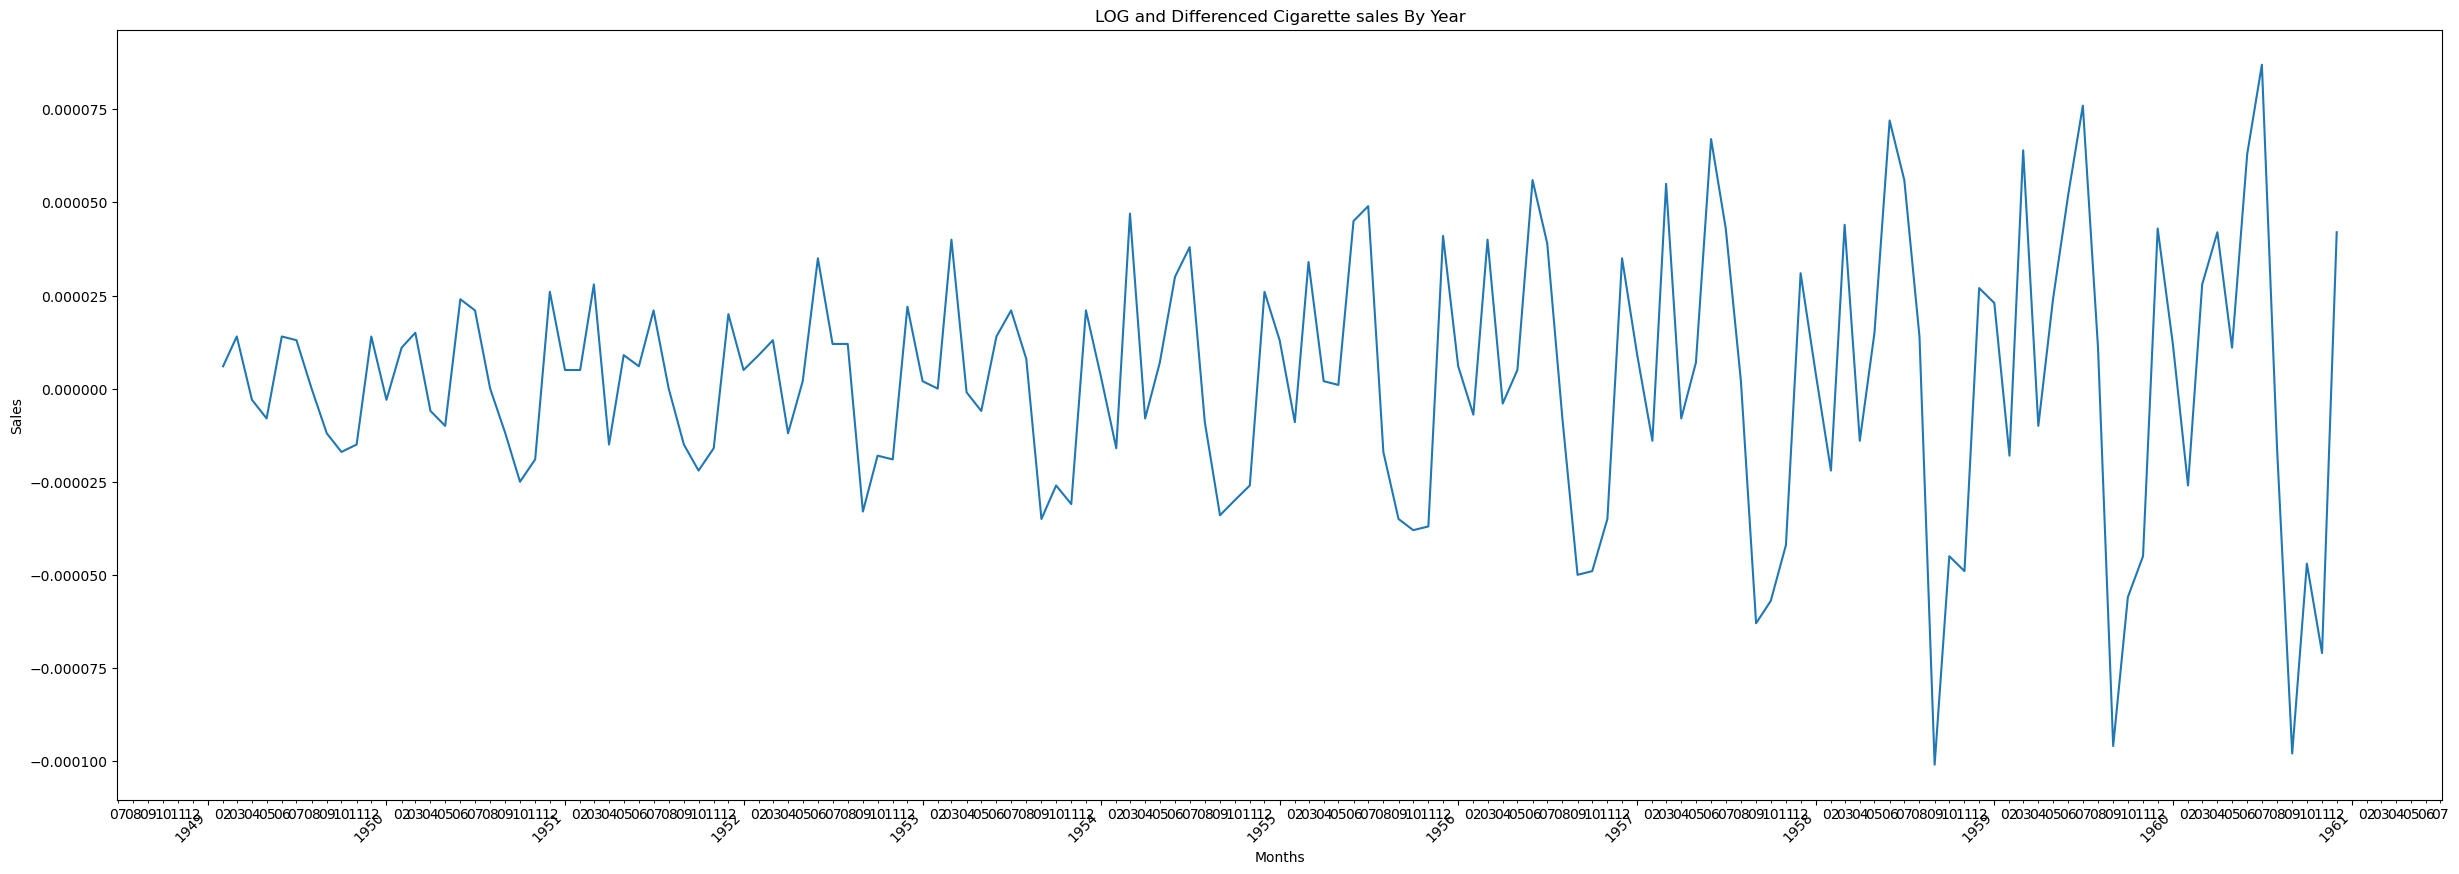

In [119]:
plot_time_series(diff_df, "LOG and Differenced Cigarette sales By Year")

<font color=teal>ACF, PACF</font>

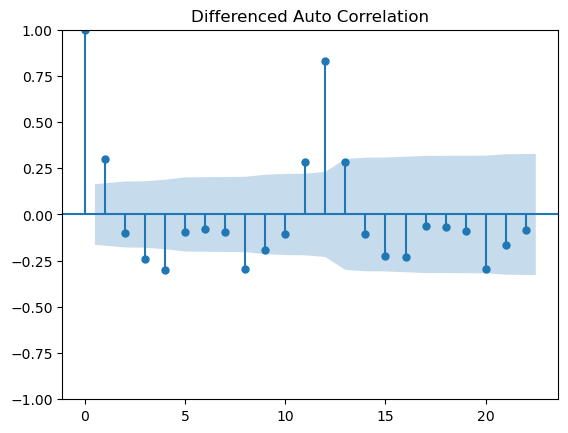

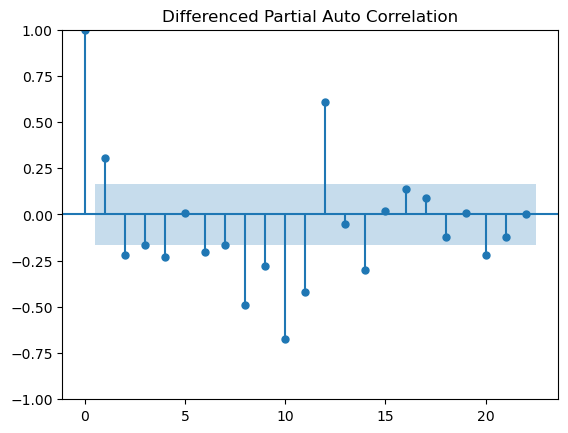

In [120]:
acf_diffed = plot_acf(diff_df, title="Differenced Auto Correlation")
pacf_diffed = plot_pacf(diff_df, title="Differenced Partial Auto Correlation")

<font color=teal>adfuller</font>

In [121]:
adf_test = adfuller(diff_df)
print(f"p-value is {adf_test[1]}")

p-value is 0.054173485621598315


<font color=teal>kpss</font>

In [122]:
_, p_value, _, criticals = kpss(diff_df)

print("p_value   :", p_value)
print("criticals :", criticals)

p_value   : 0.1
criticals : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`.

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier.

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

<font color=teal>functions is at top of this notebook</font>

In [123]:
# Now, we choose a couple of values to try for each parameter.
p = [0, 1, 2, 12]
q = [0, 1, 2, 3]


In [124]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
results, best = evaluate_arima(cigData, p, q)


In [125]:
print(f"Best value {best}")
print("Top results:")
results[0:8]

Best value {'order': (2, 1, 1), 'loss': 2.2522549152048182e-09}
Top results:


[{'order': (2, 1, 1), 'loss': 2.2522549152048182e-09},
 {'order': (2, 1, 2), 'loss': 2.3271735817278336e-09},
 {'order': (1, 1, 2), 'loss': 2.330926249695945e-09},
 {'order': (2, 1, 0), 'loss': 2.4363574069068457e-09},
 {'order': (0, 1, 1), 'loss': 2.450173661263074e-09},
 {'order': (1, 1, 1), 'loss': 2.452412341883781e-09},
 {'order': (0, 1, 3), 'loss': 2.46588023498631e-09},
 {'order': (1, 1, 0), 'loss': 2.493644892325362e-09}]

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [126]:
df_train, df_test = train_test_split(cigData)


In [127]:
model_fit = run_arima(data=df_train, order=(2,1,1))


We can take a look at a summary of the model this library has built around our data.

In [128]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              cig_sales   No. Observations:                  115
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1045.188
Date:                Tue, 13 Jun 2023   AIC                          -2082.375
Time:                        15:09:36   BIC                          -2071.430
Sample:                    01-01-1949   HQIC                         -2077.933
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4471    1.4e-19    3.2e+18      0.000       0.447       0.447
ar.L2         -0.2451   1.42e-19  -1.72e+18      0.000      -0.245      -0.245
ma.L1         -0.1065   2.04e-19  -5.21e+17      0.0

## <font color=teal>Validate data</font>

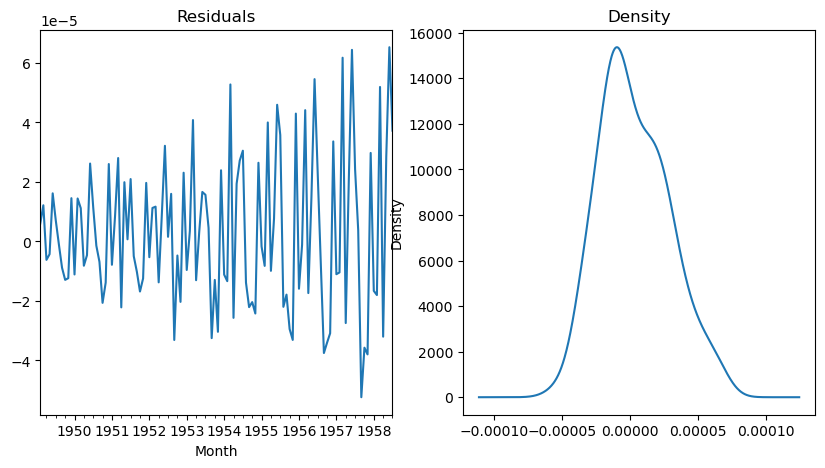

In [129]:
# from Lianne and Justin = https://www.youtube.com/watch?v=-aCF0_wfVwY
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(10,5))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()


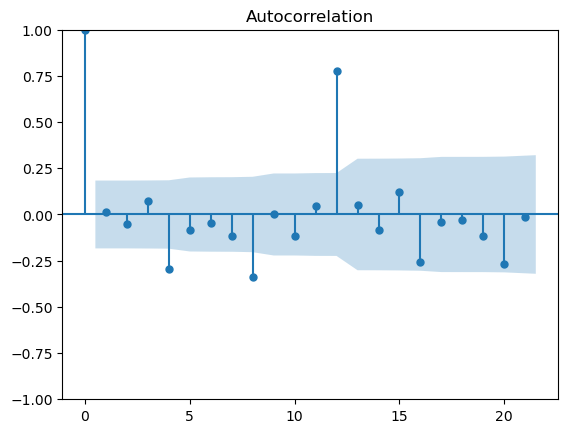

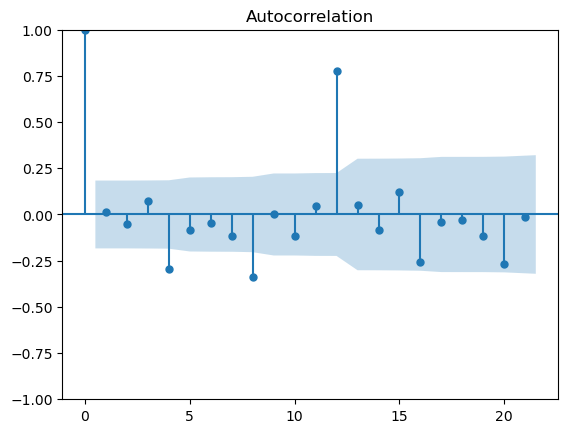

In [130]:
plot_acf(residuals)
# plot_pacf(residuals)


### 3e. Visualize the results 

Visualize the original dataset plotted against our model.

<Axes: xlabel='Month'>

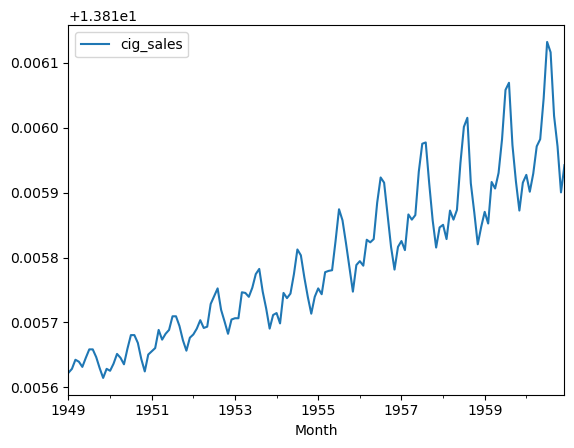

In [131]:
cigData.plot()

<Axes: >

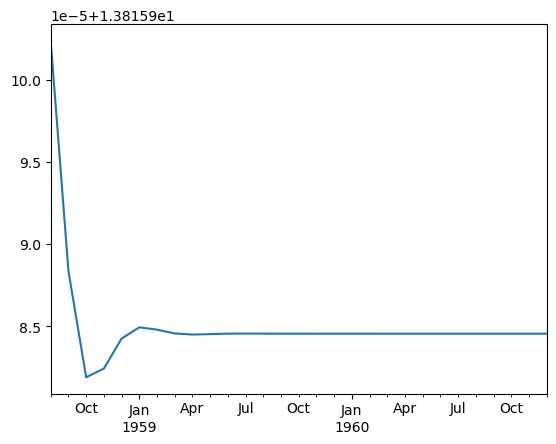

In [132]:
forcast = model_fit.forecast(len(df_test))

forcast.plot()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

<Axes: xlabel='Month'>

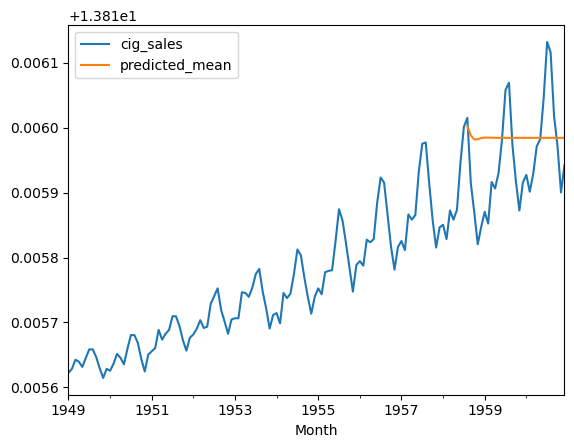

In [133]:
merge=pd.merge(cigData, forcast, how='left', left_index=True, right_index=True)

merge.plot()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 